## Calcul de $\pi$

Implémenter le calcul de $\pi$ par la méthode de Monte Carlo

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:00<00:00, 166865.08it/s]


Approximation de pi après 100000 tirages : 3.13304


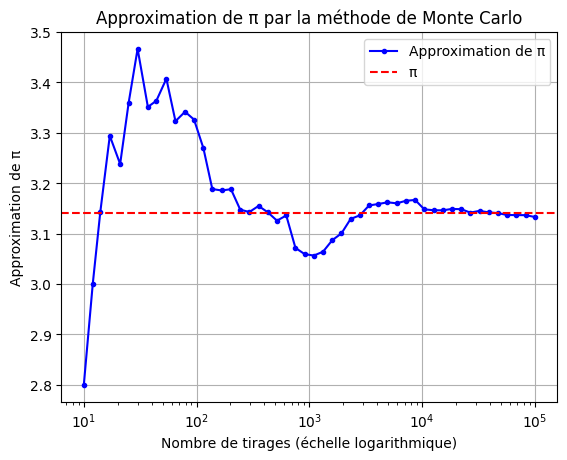

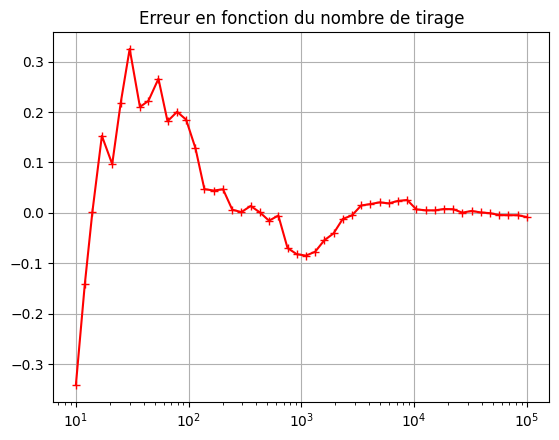

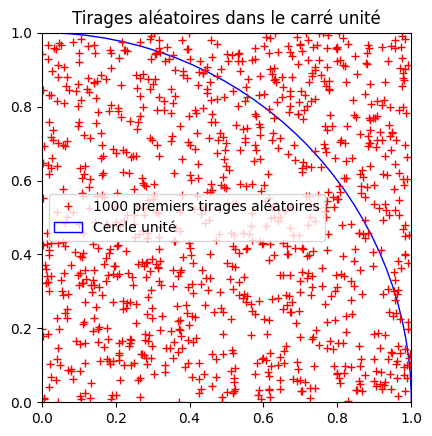

In [14]:
import numpy as np  
import matplotlib.pyplot as plt
from tqdm import tqdm


np.random.seed(0)
nombre_de_tirages = int(1e5)

# Preparer une echelle log pour l'affichage de pi par la methode de Monte Carlo
Tx=np.logspace(1, np.log10(nombre_de_tirages-1), num=50, dtype=int)
Ty=np.zeros_like(Tx, dtype=float)
T_mesure = []
# On va compter le nombre de bon tirage
nombre_de_bons_tirages = 0
for i in tqdm(range(nombre_de_tirages)): 
    # On procède à deux tirages entre 0 et 1 avec une valeur uniforme
    x,y= np.random.uniform(0,1,2) 
    if len(T_mesure)<1000:
        T_mesure.append((x,y))
    # Si la norme est inférieur à 1, alors on est dans le cercle donc le tirage est bon
    if x**2 + y**2 <= 1:
        nombre_de_bons_tirages += 1

    # Stockage des valeurs pour l'affichage de l'évolution de l'approximation
    if i in Tx:
        Ty[np.where(Tx==i)[0][0]] =  4 * nombre_de_bons_tirages / i

pi_approximation = 4 * nombre_de_bons_tirages / nombre_de_tirages
print("Approximation de pi après", nombre_de_tirages, "tirages :", pi_approximation)

# Ty = Ty - np.pi
plt.figure()
plt.xscale('log')
plt.plot(Tx, Ty, marker='.', linestyle='-', color='b', label='Approximation de π')
plt.axhline(np.pi, color='r', linestyle='--', label='π')
plt.xlabel('Nombre de tirages (échelle logarithmique)')
plt.ylabel('Approximation de π')
plt.title('Approximation de π par la méthode de Monte Carlo')
plt.legend()
plt.grid()
plt.show(block=False)

# Affichage de l'erreur en fonction du nombre de tirages
erreur = Ty-np.pi
plt.plot(Tx,erreur,'r+-')
plt.xscale('log')
plt.grid()
plt.title("Erreur en fonction du nombre de tirage")
# plt.legend()
plt.show(block=False)

plt.plot([mesure[0] for mesure in T_mesure], [mesure[1] for mesure in T_mesure], 'r+' )
circle = plt.Circle((0, 0), 1, color='b', fill=False)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Tirages aléatoires dans le carré unité")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(['1000 premiers tirages aléatoires', 'Cercle unité'])
plt.show(block=False)

# La méthode Monte Carlo appliquée au transport de particules

Considérons la configuration suivante 
- Une géométrie sphérique de rayon $R$.  
- Un matériau contenant un seul isotope (U235) dont les sections et la densité sont données dans la classe `NuclearData`. 

L'exercice consiste à construire une simulation Monte Carlo afin de 
1. Déterminer le $keff$ pour un rayon $R=1$.  
2. Déterminer le rayon critique; $R$ tel que $keff=1$.
3. Déterminer la masse critique
4. Pour le rayon critique, calculer et tracer le flux en fonction du rayon, et estimer les fuites du système.  
5. Tracer le keff en fontion du nombre de batch, Après combien de générations a-t-on atteint la stationnarité ?  
Expliquer l’origine de la non-stationnarité lors des premières générations simulées.

Pour cela, nous considérerons que 
- le noyau ne possède que 3 réactions : Fission, Capture et diffusion.  
- Le système est "mono-cinétique";  i.e. les neutrons ne changent pas d'énergie et les sections ont toujours la même valeur.
- Les neutrons sont placés initialement au centre de la sphère (on peut la considérer centrée en (0,0,0))

Ensuite, vous pouvez implémenter la simulation de la vie d'un neutron (vol, fuite, collision) pour enfin organiser le système selon la "boucle critique". 
Pour cela, vous pouvez vous appuyez sur les classes (partiellement) définies ci-dessous : `NuclearData`, `GeometrySphere`, `Neutron`.   
Quelques fonctions ont été "définies" (mais vide), je vous conseille de les remplir et les utiliser afin de structurer votre code.  
Ces fonctions sont : `sample_interaction`, `sample_uniform_direction`, `get_distance_to_boundary`, `sample_distance_to_interaction`, `simulate_neutron`.  

Les fonctions suivantes de numpy pourraient être utiles : `np.random.uniform`, `np.roots`, les fonctions classiques (`np.cos`, `np.log`, ....), `np.mean` et `np.std` (utiliser l'option `ddof=1` pour la correction de Bessel).

## Quelques données 

In [ ]:
from dataclasses import dataclass, field
import numpy as np
import copy

from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool
processes=multiprocessing.cpu_count()


@dataclass
class NuclearData:
    atomic_weight_ratio: float = 235.0
    density: float = 4.4994e-02  # at. / barn.cm
    xs_capture: float = 0.0599268
    xs_elastic: float = 3.78266
    xs_fission: float = 1.2885
    nu_bar: float = 2.64574
    xs_total: float = field(init=False)

    def __post_init__(self):
        self.xs_total = self.xs_capture + self.xs_elastic + self.xs_fission

    def get_macro_xs(self, reaction):
        return self.density * self.get_xs(reaction)

    def get_xs(self, reaction):
        if reaction.lower() == "capture":
            return self.xs_capture
        if reaction.lower() == "fission":
            return self.xs_fission
        if reaction.lower() == "elastic":
            return self.xs_elastic
        if reaction.lower() == "total":
            return self.xs_total
        raise ValueError(
            f"Reaction {reaction} is not accepted. Accepted values are: capture, fission, elastic, total"
        )

    def sample_interaction(self):
        """ Select the interaction : return string : 'capture', ... 
        """
        interactions=['capture', 'fission', 'elastic']
        probabilities=[self.xs_capture/self.xs_total, self.xs_fission/self.xs_total, self.xs_elastic/self.xs_total]
        return np.random.choice(interactions, p=probabilities)


def sample_uniform_direction():
    """ Sample a uniform direction 
    """
    vec = np.random.uniform(-1, 1, 3)
    return vec / np.linalg.norm(vec)  



@dataclass
class GeometrySphere:
    radius: float = 1.0
    center: np.ndarray = field(default_factory=lambda: np.zeros(3))

    def get_distance_to_boundary(self, pos, dir):
        """
        Compute the exiting distance from the sphere for a particle at position 'pos' with direction 'dir'
        """
        oc = pos - self.center
        b = 2.0 * np.dot(dir, oc)
        c = np.dot(oc, oc) - self.radius**2
        delta = b*b - 4*c

        if delta < 0:
            print("Erreur : le neutron est à l'extérieur de la sphère et ne va pas rentrer.")
            return np.inf  # Pas d'intersection

        sqrt_delta = np.sqrt(delta)
        t1 = (-b - sqrt_delta) / 2.0
        t2 = (-b + sqrt_delta) / 2.0

        if t2 < 0:
            print("Erreur : le neutron est à l'extérieur de la sphère et se dirige vers l'extérieur.")
            return np.inf  # Sortie dans le sens opposé

        return t2
    
    def neutron_in_sphere(self, pos):
        """Est ce que le neutron est dans la sphère

        Args:
            pos (np.ndarray): _position du neutron_

        Returns:
            boolean: True ou False
        """
        distance = np.linalg.norm(pos - self.center)  
        if distance < self.radius:
            return True
        return False

@dataclass
class Neutron:
    position: np.ndarray
    direction: np.ndarray

    def __post_init__(self):
        self._normalize_direction()

    def _normalize_direction(self):
        norm = np.linalg.norm(self.direction)
        self.direction /= norm
    
    def set_direction(self, vec):
        self.direction = vec
        self._normalize_direction()

    def move_distance(self, distance):
        self.position += self.direction * distance

def sample_distance_to_interaction(sigma_t):
    """
    Sample the distance to the next interaction from the total cross section
    """
    return -1/sigma_t * np.log(1-np.random.rand())

def simulate_neutron(neutron):
    """
    Simulate the life of a neutron. 
    Eventually return fission neutrons in a list if a fission happened
    """

    # On choisit l'interaction
    distance = sample_distance_to_interaction(data.get_macro_xs("total"))
    neutron.move_distance(distance)

    interaction=data.sample_interaction()
    while interaction == 'elastic':
        distance = sample_distance_to_interaction(data.get_macro_xs("total"))
        neutron.move_distance(distance)

        # On verifie si le neutron est sorti de la boule
        if geometry.neutron_in_sphere(neutron.position)==False:
            return [] # Si il est sorti, il est mort

        # On choisit la nouvelle direction
        neutron.set_direction(sample_uniform_direction())
        interaction = data.sample_interaction()
    
    
    if interaction=='fission': # Si c'est une fission, on crée de nouveaux neutrons
        new_neutron=[Neutron(neutron.position.copy(), sample_uniform_direction()) for _ in range(np.random.poisson(data.nu_bar))]
        return new_neutron
    
    if interaction=='capture': # Si c'est une capture, le neutron disparait
        return []
    
    assert False, "Erreur, pas d'interaction"


# rayon pour démarrer
rayon = 8.44  # cm
np.random.seed(0)

data = NuclearData()
geometry = GeometrySphere(radius=rayon)
nb_neutrons_per_batch = 10000
nb_batches = 50 # 110
starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction()) for i in range(nb_neutrons_per_batch)]
keff = np.zeros(nb_batches)

for i in tqdm(range(nb_batches)):
    output_neutrons = []

    for neutron in starting_neutrons:
        new_neutrons = simulate_neutron(neutron)
        output_neutrons += new_neutrons

    # with Pool(processes) as pool:
    #     results = pool.map(simulate_neutron, starting_neutrons)
    # output_neutrons = [n for sub in results for n in sub]

    keff[i] = len(output_neutrons) / nb_neutrons_per_batch
    # print(f"Generation {i}: keff = {keff[i]} avec {len(output_neutrons)} neutrons")

    starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Moyenne de keff après stabilisation : 0.9714600000000001
Ecart type de keff après stabilisation : 0.057902197624925426


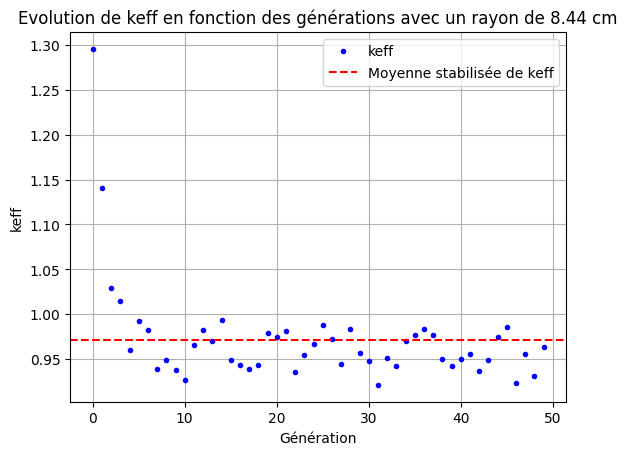

In [17]:
import matplotlib.pyplot as plt

moyenne_keff = np.mean(keff[-100:])  # Moyenne sans le début instable
print(f"Moyenne de keff après stabilisation : {moyenne_keff}")
ecart_type_keff = np.std(keff[-100:],ddof=1)
print(f"Ecart type de keff après stabilisation : {ecart_type_keff}")

plt.plot(keff, 'b.', label='keff')
plt.axhline(moyenne_keff, color='r', linestyle='--', label='Moyenne stabilisée de keff')
plt.title("Evolution de keff en fonction des générations avec un rayon de {:.2f} cm".format(rayon))
plt.xlabel("Génération")
plt.ylabel("keff")
plt.grid()
plt.legend()
plt.show()



# rho = 19.05 # g/cm3 pour l'uranium 235
# masse_critique = 48*1e3  # g
# rayon = (3 * masse_critique / (4 * np.pi * rho))**(1/3)
# print(f"Rayon critique estimé : {rayon} cm")


Calcul de keff pour un rayon de 6.0 cm


100%|██████████| 250/250 [01:50<00:00,  2.25it/s]


Calcul de keff pour un rayon de 6.1 cm


100%|██████████| 250/250 [01:46<00:00,  2.34it/s]


Calcul de keff pour un rayon de 6.2 cm


100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


Calcul de keff pour un rayon de 6.3 cm


100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


Calcul de keff pour un rayon de 6.4 cm


100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


Calcul de keff pour un rayon de 6.5 cm


100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


Calcul de keff pour un rayon de 6.6 cm


100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


Calcul de keff pour un rayon de 6.7 cm


100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


Calcul de keff pour un rayon de 6.8 cm


100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Calcul de keff pour un rayon de 6.9 cm


100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Calcul de keff pour un rayon de 7.0 cm


100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


Calcul de keff pour un rayon de 7.1 cm


100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Calcul de keff pour un rayon de 7.2 cm


100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Calcul de keff pour un rayon de 7.3 cm


100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Calcul de keff pour un rayon de 7.4 cm


100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


Calcul de keff pour un rayon de 7.5 cm


100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Calcul de keff pour un rayon de 7.6 cm


100%|██████████| 250/250 [01:52<00:00,  2.23it/s]


Calcul de keff pour un rayon de 7.7 cm


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Calcul de keff pour un rayon de 7.8 cm


100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


Calcul de keff pour un rayon de 7.9 cm


100%|██████████| 250/250 [01:51<00:00,  2.24it/s]


Calcul de keff pour un rayon de 8.0 cm


100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


Calcul de keff pour un rayon de 8.1 cm


100%|██████████| 250/250 [01:48<00:00,  2.29it/s]


Calcul de keff pour un rayon de 8.2 cm


100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Calcul de keff pour un rayon de 8.3 cm


100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


Calcul de keff pour un rayon de 8.4 cm


100%|██████████| 250/250 [01:48<00:00,  2.29it/s]


Calcul de keff pour un rayon de 8.5 cm


100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


Calcul de keff pour un rayon de 8.6 cm


100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Calcul de keff pour un rayon de 8.7 cm


100%|██████████| 250/250 [01:52<00:00,  2.23it/s]


Calcul de keff pour un rayon de 8.8 cm


100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Calcul de keff pour un rayon de 8.9 cm


100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Calcul de keff pour un rayon de 9.0 cm


100%|██████████| 250/250 [01:51<00:00,  2.24it/s]


Calcul de keff pour un rayon de 9.1 cm


100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


Calcul de keff pour un rayon de 9.2 cm


100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


Calcul de keff pour un rayon de 9.3 cm


100%|██████████| 250/250 [01:51<00:00,  2.25it/s]


Calcul de keff pour un rayon de 9.4 cm


100%|██████████| 250/250 [01:51<00:00,  2.24it/s]


Calcul de keff pour un rayon de 9.5 cm


100%|██████████| 250/250 [01:52<00:00,  2.23it/s]


Calcul de keff pour un rayon de 9.6 cm


100%|██████████| 250/250 [01:57<00:00,  2.12it/s]


Calcul de keff pour un rayon de 9.7 cm


100%|██████████| 250/250 [01:58<00:00,  2.11it/s]


Calcul de keff pour un rayon de 9.8 cm


100%|██████████| 250/250 [01:51<00:00,  2.24it/s]


Calcul de keff pour un rayon de 9.9 cm


100%|██████████| 250/250 [01:51<00:00,  2.24it/s]


Calcul de keff pour un rayon de 10.0 cm


100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


Calcul de keff pour un rayon de 10.1 cm


100%|██████████| 250/250 [01:51<00:00,  2.23it/s]


Calcul de keff pour un rayon de 10.2 cm


100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


Calcul de keff pour un rayon de 10.3 cm


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]


Calcul de keff pour un rayon de 10.4 cm


100%|██████████| 250/250 [01:56<00:00,  2.15it/s]


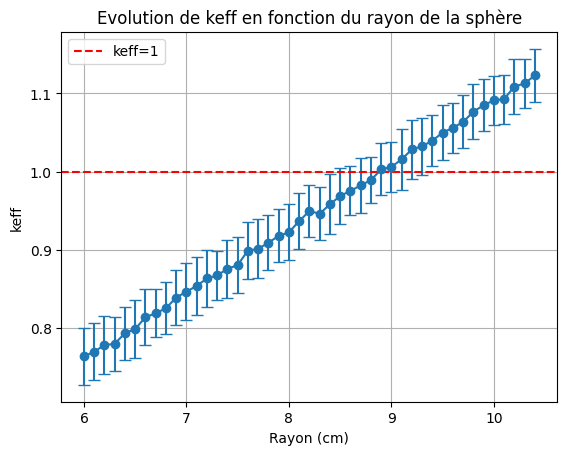

In [ ]:
def calculer_keff(rayon, nb_batches=110, nb_neutrons_per_batch=10000):
    """_summary_

    Args:
        rayon (_type_): _description_
        nb_batches (int, optional): _description_. Defaults to 110.
        nb_neutrons_per_batch (int, optional): _description_. Defaults to 10000.
    """
    np.random.seed(0)

    nb_neutrons_per_batch = 10000
    nb_batches = 250
    starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction()) for i in range(nb_neutrons_per_batch)]
    keff = np.zeros(nb_batches)
    global data, geometry
    data = NuclearData()
    geometry = GeometrySphere(radius=rayon)

    # for i in tqdm(range(nb_batches)):
    for i in range(nb_batches):
        output_neutrons = []

        # for neutron in starting_neutrons:
        #     new_neutrons = simulate_neutron(neutron)
        #     output_neutrons += new_neutrons

        with Pool(processes) as pool:
            results = pool.map(simulate_neutron, starting_neutrons)
        output_neutrons = [n for sub in results for n in sub]

        keff[i] = len(output_neutrons) / nb_neutrons_per_batch

        starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

    moyenne_keff = np.mean(keff[:])  # Moyenne sans le début instable
    ecart_type_keff = np.std(keff[:],ddof=1)
    return moyenne_keff, ecart_type_keff


def trouver_la_masse_critique(rayon_initial=0, precision=1e-2):
    """Trouver la masse critique en cherchant le rayon critique

    Args:
        rayon_min (float): rayon minimum
        rayon_max (float): rayon maximum
        precision (float): précision en cm

    Returns:
        float: masse critique en g
    """
    # rayon pour démarrer
    rayon = rayon_initial  # cm
    keff_1 = calculer_keff(rayon)
    keff_2 = calculer_keff(rayon + 1)  

    # Descente de gradient
    while abs(keff_2-1) > precision:
        print(keff_2,1e2*(keff_2-keff_1))
        rayon -= 1e1*(keff_2-keff_1)
        keff_1 = keff_2
        keff_2 = calculer_keff(rayon)
        print(f"Rayon: {rayon} cm, keff: {keff_2}")

# trouver_la_masse_critique(rayon_initial=8, precision=1e-2)

Trayon = np.arange(6,10.5,0.1)
Tkeff=[]
for rayon in Trayon:
    print("Calcul de keff pour un rayon de {:.1f} cm".format(rayon))
    Tkeff.append(calculer_keff(rayon))

fichier = open("masse_critique.txt", "w")
fichier.write("Rayon(cm);keff mean;keff std;masse critique(g)\n")
for i in range(len(Trayon)):
    rho = 19.05 # g/cm3 pour l'uranium 235
    masse_critique = 4/3 * np.pi * Trayon[i]**3 * rho  # g
    fichier.write("{:.3f};{:.3f};{:.3f};{:.3f}\n".format(Trayon[i], Tkeff[i][0], Tkeff[i][1], masse_critique))
fichier.close()    

import matplotlib.pyplot as plt

# plt.plot(Trayon,[keff[0] for keff in Tkeff],'b+-')
plt.errorbar(Trayon, [keff[0] for keff in Tkeff], yerr=[keff[1] for keff in Tkeff], fmt='o-', capsize=4)
plt.axhline(1, color='r', linestyle='--', label='keff=1')
plt.title("Evolution de keff en fonction du rayon de la sphère")
plt.xlabel("Rayon (cm)")
plt.ylabel("keff")
plt.grid()
plt.legend()
plt.show()

    
    